In [1]:
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import cv2
import imgaug.augmenters as iaa

from dataset import cardiac_dataset
from dataset.cardiac_dataset import CardiacDataset




In [3]:
import sys
print(sys.path)

['C:\\Users\\Owner', 'C:\\Anaconda\\envs\\pytorch\\python311.zip', 'C:\\Anaconda\\envs\\pytorch\\DLLs', 'C:\\Anaconda\\envs\\pytorch\\Lib', 'C:\\Anaconda\\envs\\pytorch', '', 'C:\\Anaconda\\envs\\pytorch\\Lib\\site-packages', 'C:\\Anaconda\\envs\\pytorch\\Lib\\site-packages\\win32', 'C:\\Anaconda\\envs\\pytorch\\Lib\\site-packages\\win32\\lib', 'C:\\Anaconda\\envs\\pytorch\\Lib\\site-packages\\Pythonwin']


In [4]:
train_root_path = "C:/Users/Owner/Downloads/Udemy/Pytorch/05-Detection/Processed-Heart-Detection/train/"
train_subjects = "C:/Users/Owner/Downloads/Udemy/Pytorch/05-Detection/05-Detection/train_subjects.npy"
val_root_path = "C:/Users/Owner/Downloads/Udemy/Pytorch/05-Detection/Processed-Heart-Detection/val/"
val_subjects = "C:/Users/Owner/Downloads/Udemy/Pytorch/05-Detection/05-Detection/val_subjects.npy"

train_transforms = iaa.Sequential([
                                iaa.GammaContrast(),
                                iaa.Affine(
                                    scale=(0.8, 1.2),
                                    rotate=(-10, 10),
                                    translate_px=(-10, 10)
                                )
                            ])

In [5]:
train_dataset = CardiacDataset(
    "C:/Users/Owner/Downloads/Udemy/Pytorch/05-Detection/05-Detection/rsna_heart_detection.csv", 
    train_subjects, train_root_path, train_transforms)

val_dataset = CardiacDataset(
    "C:/Users/Owner/Downloads/Udemy/Pytorch/05-Detection/05-Detection/rsna_heart_detection.csv", 
    val_subjects, val_root_path, None)


In [6]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [7]:
train_dataset = CardiacDataset(
    "C:/Users/Owner/Downloads/Udemy/Pytorch/05-Detection/05-Detection/rsna_heart_detection.csv",
     train_subjects,
     train_root_path,
     augs = train_transforms)

val_dataset = CardiacDataset(
    "C:/Users/Owner/Downloads/Udemy/Pytorch/05-Detection/05-Detection/rsna_heart_detection.csv",
     val_subjects,
     val_root_path,
     augs=None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 400 train images and 96 val images


In [8]:
batch_size = 8#TODO
num_workers = 4# TODO


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


In [9]:
class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512 ,out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()
        
    def forward(self, data):
        return self.model(data)
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        
        self.log("Train Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        
        self.log("Val Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            
            img = ((x_ray[i] * 0.252)+0.494).numpy()[0]
            
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)
            
            results.append(torch.tensor(img).unsqueeze(0))
        
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(name, grid, self.global_step)
        
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]


In [10]:
class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18(pretrained=True)
        
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 4
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")

        return loss
    
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label

        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        
        loss = self.loss_fn(pred, label)
        self.log("Val Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        # Here we create a grid consisting of 4 predictions
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            img = ((x_ray[i] * 0.252)+0.494).numpy()[0]
            
            # Extract the coordinates from the label
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            # Extract the coordinates from the prediction           
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)
            
            
            results.append(torch.tensor(img).unsqueeze(0))
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(f"{name} Prediction vs Label", grid, self.global_step)

            
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



In [11]:
# Create the model object
model = CardiacDetectionModel()  # Instanciate the model

C:\Anaconda\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Anaconda\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min')

In [13]:
gpus = 1 #TODO
trainer = pl.Trainer(
    devices=gpus,  
    logger=TensorBoardLogger("./logs"),
    log_every_n_steps=1,
    default_root_dir="./weights",
    callbacks=checkpoint_callback,
    max_epochs=100
)

NameError: name 'gpus' is not defined

In [39]:
# Train the detection model
trainer.fit(model, train_loader, val_loader)

Missing logger folder: ./logs\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | model   | ResNet  | 11.2 M
1 | loss_fn | MSELoss | 0     
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.689    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.load_from_checkpoint("C:/Users/Owner/Downloads/Udemy/Pytorch/05-Detection/05-Detection/weight.ckpt")
model.eval();
model.to(device)

C:\Anaconda\envs\pytorch\Lib\site-packages\pytorch_lightning\utilities\migration\migration.py:201: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
Lightning automatically upgraded your loaded checkpoint from v1.3.5 to v2.0.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\Owner\Downloads\Udemy\Pytorch\05-Detection\05-Detection\weight.ckpt`
C:\Anaconda\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Anaconda\envs\pytorch\Lib\s

CardiacDetectionModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [43]:
preds = []
labels = []

with torch.no_grad():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0)
        pred = model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)
        
preds=torch.stack(preds) #convert into torch tensor
labels=torch.stack(labels)

In [50]:
abs(preds-labels).mean(0)
# the results is the mean value of the mean difference prediction and labels (smaller is more accurate)
# the result that you got is around 6 to 8 pixels of error (around 5% error)

tensor([8.3512, 5.5593, 5.9868, 5.7377])

tensor([ 97,  60, 176, 149])


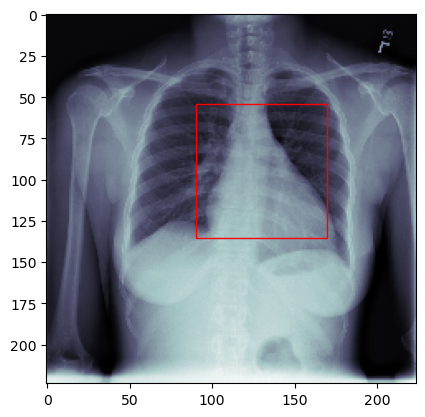

In [53]:
IDX = 20  # Feel free to inspect all validation samples by changing the index
img, label = val_dataset[IDX]
current_pred = preds[IDX]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
heart = patches.Rectangle((current_pred[0], current_pred[1]), current_pred[2]-current_pred[0],
                          current_pred[3]-current_pred[1], linewidth=1, edgecolor='r', facecolor='none')
axis.add_patch(heart)

print(label)